In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
 
import tensorflow as tf
 
from tensorflow.python.platform import tf_logging as logging
 
logging.set_verbosity(logging.INFO)
logging.log(logging.INFO, "Tensorflow version " + tf.__version__)
 
 
def generate_time_series(datalen):
    freq1 = 0.2
    freq2 = 0.15
    noise = [np.random.random() * 0.1 for i in range(datalen)]
    x1 = np.sin(np.arange(0, datalen) * freq1) + noise
    x2 = np.sin(np.arange(0, datalen) * freq2) + noise
    x = x1 + x2
    return x.astype(np.float32)
 
 
DATA_SEQ_LEN = 24000
 
data = generate_time_series(DATA_SEQ_LEN)

INFO:tensorflow:Tensorflow version 1.11.0


In [8]:
data

array([ 0.1286493 ,  0.39944476,  0.82925016, ..., -1.3532078 ,
       -1.1036639 , -0.9099206 ], dtype=float32)

In [2]:
SEQLEN = 16  # unrolled sequence length
BATCHSIZE = 32
 
X = data
Y = np.roll(data, -1)
 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=.2,
                                                    random_state=0)
 
X_train = np.reshape(X_train, [-1, SEQLEN])
Y_train = np.reshape(Y_train, [-1, SEQLEN])
 
X_test = np.reshape(X_test, [-1, SEQLEN])
Y_test = np.reshape(Y_test, [-1, SEQLEN])
 
 
def train_dataset():
    dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(DATA_SEQ_LEN * 4 // SEQLEN)
    dataset = dataset.batch(BATCHSIZE)
    samples, labels = dataset.make_one_shot_iterator().get_next()
    return samples, labels
 
 
def eval_dataset():
    evaldataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    evaldataset = evaldataset.repeat(1)
    evaldataset = evaldataset.batch(BATCHSIZE)
 
    samples, labels = evaldataset.make_one_shot_iterator().get_next()
    return samples, labels

In [3]:
RNN_CELLSIZE = 80
N_LAYERS = 2
DROPOUT_PKEEP = 0.7
 
def model_rnn_fn(features, labels, mode):
    
    X = tf.expand_dims(features, axis=2)
 
    batchsize = tf.shape(X)[0]
    seqlen = tf.shape(X)[1]
 
    cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE) for _ in range(N_LAYERS)]
 
    cells[:-1] = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=DROPOUT_PKEEP) for cell in cells[:-1]]
    # a stacked RNN cell still works like an RNN cell
    cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=False)
 
    # X[BATCHSIZE, SEQLEN, 1], Hin[BATCHSIZE, RNN_CELLSIZE*N_LAYERS]
    Yn, H = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
 
    Yn = tf.reshape(Yn, [batchsize * seqlen, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1)  # Yr [BATCHSIZE*SEQLEN, 1]
    Yr = tf.reshape(Yr, [batchsize, seqlen, 1])  # Yr [BATCHSIZE, SEQLEN, 1]
 
    Yout = Yr[:, -1, :]  # Last output Yout [BATCHSIZE, 1]
 
    loss = train_op = None
    if mode != tf.estimator.ModeKeys.PREDICT:
        labels = tf.expand_dims(labels, axis=2)
        loss = tf.losses.mean_squared_error(Yr, labels)  # la  bels[BATCHSIZE, SEQLEN, 1]
        lr = 0.001
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
 
        train_op = tf.contrib.training.create_train_op(loss, optimizer)
 
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={"Yout": Yout},
        loss=loss,
        train_op=train_op
    )


In [5]:
training_config = tf.estimator.RunConfig(model_dir="./outputdir")
estimator = tf.estimator.Estimator(model_fn=model_rnn_fn, config=training_config)

INFO:tensorflow:Using config: {'_model_dir': './outputdir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a2b2cec18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:

estimator.train(input_fn=train_dataset,steps=2000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./outputdir/model.ckpt.
INFO:tensorflow:loss = 1.0955391, step = 1
INFO:tensorflow:global_step/sec: 37.7754
INFO:tensorflow:loss = 0.047451973, step = 101 (2.648 sec)
INFO:tensorflow:global_step/sec: 41.7516
INFO:tensorflow:loss = 0.048803154, step = 201 (2.395 sec)
INFO:tensorflow:global_step/sec: 44.8928
INFO:tensorflow:loss = 0.043289464, step = 301 (2.227 sec)
INFO:tensorflow:global_step/sec: 45.4848
INFO:tensorflow:loss = 0.047288463, step = 401 (2.199 sec)
INFO:tensorflow:global_step/sec: 44.3633
INFO:tensorflow:loss = 0.042700764, step = 501 (2.254 sec)
INFO:tensorflow:global_step/sec: 44.6121
INFO:tensorflow:loss = 0.04310859, step = 601 (2.242 sec)
INFO:tensorflow:global_step/sec: 46.4581
INFO:tenso

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


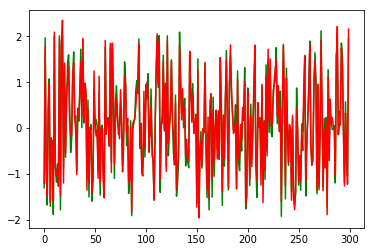

In [7]:
results = estimator.predict(eval_dataset)
 
Yout_ = [result["Yout"] for result in results]
 
actual = Y_test[:, -1]
 
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(actual, label="Actual Values", color='green')
plt.plot(Yout_, label="Predicted Values", color='red', )
 
plt.show()